<h1 style = 'color:purple' align ='center'>1. Real Estate Price Predition in Bangalore Project </h1>

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import json

In [2]:
# Configure Plot
mpl.rcParams['figure.figsize'] = (20,10)

## Data Load: Load banglore home prices into a dataframe

In [6]:
# Load Data
df1 = pd.read_csv("..\data\Bengaluru_House_Data.csv")
df1.head() # First 5 rows

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [7]:
df1.shape # Size

(13320, 9)

**Drop features that are not required to build our model**

In [8]:
# Drop unnecessary columns
df2 = df1.drop(['area_type','society','balcony','availability'],axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Data Cleaning : Handle NA values

In [9]:
# Data Cleaning --> Removing NULL Values
df2.dropna(inplace=True) # inplace : bool, default False --> Whether to modify the DataFrame rather than creating a new one.

In [10]:
# Drop NULL Value Rows 
df2.isnull().sum()# Total no.of NULL Values in Each column

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df2.shape # Size Reduced--> Rows Removed

(13246, 5)

## Feature Engineering

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [12]:
# Cleaning Each Column by observing

# List all unique values

df2['size'].unique() 

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [13]:
# Extracting Digits from Size Column

df2['bhk']=df2['size'].str.split().str[0].astype(int)

In [14]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [15]:
# Observing total_sqft values
df2['total_sqft'].unique() # It include Ranges also

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

**Explore total_sqft feature**

In [17]:
# Identifing Non float Values
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [18]:
# Identifing Non float Values
df2[~df2['total_sqft'].apply(is_float)].head(10) # Non Uniformities

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [19]:
# Handle 'total_sqft' column by calculating average if range
def convert_sqft_to_num(x):
    if '-' in x:
        min_sqft , max_sqft = map(float, x.split('-'))
        return (min_sqft + max_sqft)/2
    try:
        return float(x)
    except:
        return np.nan # returns numerical null Value of float type

In [20]:
df3 = df2.copy() #deep Copy
df3['total_sqft'] = df3['total_sqft'].apply(convert_sqft_to_num)

In [21]:
df3[~df3['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bhk


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [22]:
# Watching Particular Index
df3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

## Feature Engineering

**Add new feature called price per square feet**

In [23]:
df4 = df3.copy()
df4['price per Sq.ft'] = df4['price']*100000/df4['total_sqft']
df4.head()

,location,size,total_sqft,bath,price,bhk,price per Sq.ft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [24]:
len(df4['location'].unique()) # High Dimension Problem

1304

**Applying dimensionality reduction technique to reduce number of locations**

In [25]:
df4['location'] = df4.location.str.strip()
location_stats = df4['location'].value_counts(ascending=False)
location_stats

location
Whitefield                           535
Sarjapur  Road                       392
Electronic City                      304
Kanakpura Road                       266
Thanisandra                          236
                                    ... 
Duddanahalli                           1
Beml layout, Rajarajeshwari nagar      1
Sabari Nagar                           1
Ashraya Layout                         1
Whitefield ECC Road                    1
Name: count, Length: 1293, dtype: int64

In [26]:
location_stats.index

Index(['Whitefield', 'Sarjapur  Road', 'Electronic City', 'Kanakpura Road',
       'Thanisandra', 'Yelahanka', 'Uttarahalli', 'Hebbal', 'Marathahalli',
       'Raja Rajeshwari Nagar',
       ...
       '1Kasavanhalli', 'Kanakapura Road,', 'Subhash Nagar', 'Jogupalya',
       'Doddanakunte', 'Duddanahalli', 'Beml layout, Rajarajeshwari nagar',
       'Sabari Nagar', 'Ashraya Layout', 'Whitefield ECC Road'],
      dtype='object', name='location', length=1293)

In [27]:
# Count of areas have less than 10 house data

len(location_stats[location_stats <= 10])

1052

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [28]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Nagadevanahalli                      10
Ganga Nagar                          10
Kalkere                              10
BTM 1st Stage                        10
Sector 1 HSR Layout                  10
                                     ..
Duddanahalli                          1
Beml layout, Rajarajeshwari nagar     1
Sabari Nagar                          1
Ashraya Layout                        1
Whitefield ECC Road                   1
Name: count, Length: 1052, dtype: int64

In [29]:
df4.location = df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [30]:
len(df4.location.unique())

242

## Outlier Removal

<h3 style="color:blue">Outlier Removal Using Business Logic</h3>

In [31]:
df4[df4.total_sqft/df4.bhk<300].head() #ununsual, anamoly , Data error , outlier

,location,size,total_sqft,bath,price,bhk,price per Sq.ft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**We can observe 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [32]:
# Remove Outliers based on business logic (sqft per bedroom)
df5 = df4[df4.total_sqft/df4.bhk>= 300]

<h3 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h3>

In [33]:
df5['price per Sq.ft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price per Sq.ft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices.**

In [34]:
def remove_locationwise_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mu = np.mean(subdf['price per Sq.ft'])
        st = np.std(subdf['price per Sq.ft'])
        reduced_df = subdf[(subdf['price per Sq.ft']>(mu-st)) & (subdf['price per Sq.ft']<=(mu+st))]
        df_out =pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [35]:
df6 = remove_locationwise_outliers(df5)
df6.shape

(10241, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

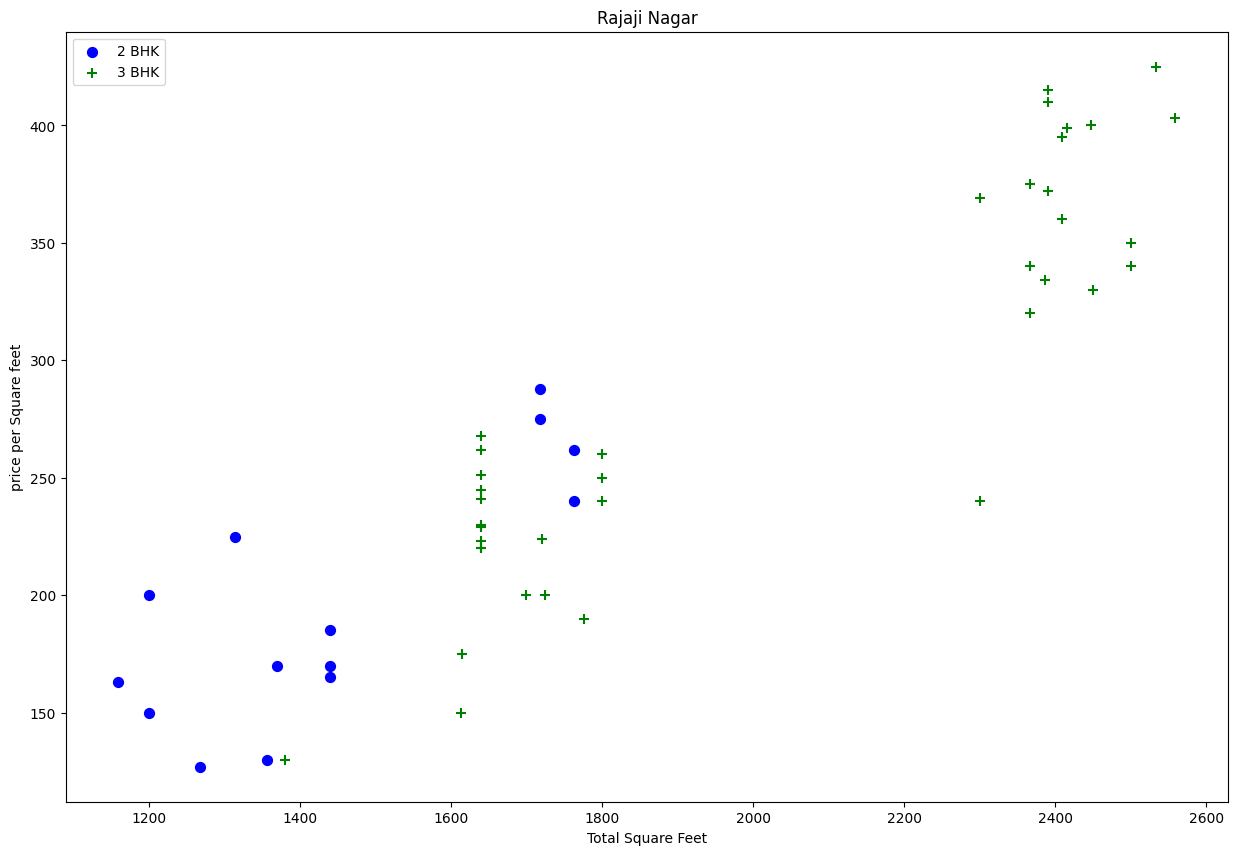

In [36]:
def scatter_plot(df,location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)] 
    mpl.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2['price'],c='blue',label = '2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3['price'],c='green',marker='+',s=50,label = '3 BHK')
    plt.xlabel('Total Square Feet')
    plt.ylabel('price per Square feet')
    plt.title(location)
    plt.legend()


    
scatter_plot(df6,'Rajaji Nagar')

    
    
    

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area).Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [37]:
# Remove outliers based on price per Sq.ft comparison for 2 BHK and 3 BHK
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for _,location_df in df.groupby('location'):
         # Dictionary comprehension
        bhk_stats={ bhk:
                {'mean':np.mean(bhk_df['price per Sq.ft']),
                'std':np.std(bhk_df['price per Sq.ft']),
                'count':bhk_df.shape[0]}
        for bhk,bhk_df in location_df.groupby('bhk')} # Nested Dictionary 
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices,bhk_df[bhk_df['price per Sq.ft'] < stats['mean']].index.values)
    return df.drop(exclude_indices, axis ='index')
    
            
    

In [38]:
df7 = remove_bhk_outliers(df6)
df7.shape

(7329, 7)

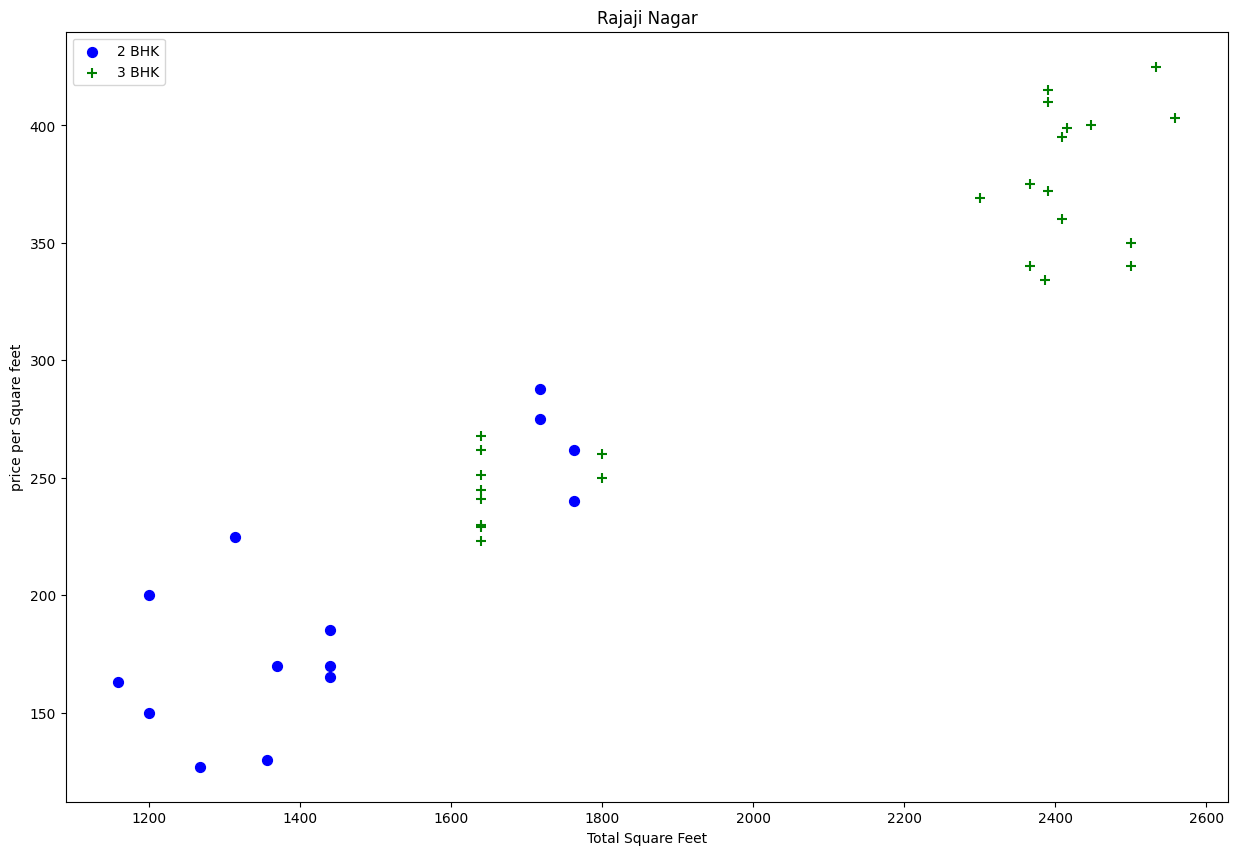

In [39]:
scatter_plot(df7,'Rajaji Nagar')

<h3 style='color:blue'>Outlier Removal using Bathroom Feature<h3>

In [40]:
df7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [41]:
# Unusual case 
df7[df7['bath']>(df7['bhk']+2)]

,location,size,total_sqft,bath,price,bhk,price per Sq.ft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [42]:
df8 = df7[df7['bath']<(df7['bhk']+2)] # Removing bathroom outliers 
df8.shape

(7251, 7)

In [43]:
df9 = df8.drop(['size','price per Sq.ft'],axis='columns') # price per Sq.ft is created to detect outliers, 'size' is not required as 'bhk' is there
df9.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


<h3 style="color:blue"> One Hot Encoding Categorical Variables </h3>


In [44]:
dummies = pd.get_dummies(df9.location,dtype=int)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can remove one location as we can consider it when remaining all zeros condition..Removing 'Others' location

In [45]:
df10 = pd.concat([df9,dummies.drop('other',axis = 'columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df11 = df10.drop('location', axis='columns') # We can remove 'location' column as well as we encoded it's values
df11.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3 style='color:blue'>Building Model</h3>

In [47]:
df11.shape

(7251, 245)

In [54]:
# Features
X = df11.drop('price',axis='columns')
y = df11.price

In [55]:
# Splitting Data set into traing and Testing Data Set
X_train ,  X_test ,y_train , y_test = train_test_split(X,y,test_size=0.2,random_state= 10)

In [56]:
# Train Linear Regression Model
lr_clf = LinearRegression()
lr_clf.fit(X_train , y_train) # Training Model
lr_clf.score(X_test,y_test) # Testing Model

0.8452277697874374

<h3 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h3>

In [57]:
# K-Fold Cross Validation
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
cross_val_score(lr_clf,X,y,cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

<h3 style='color:blue'>Find best model using GridSearchCV</h3>

In [58]:
# Grid Search for Best Model

def find_best_model_using_gridsearchcv(X,y):
    algos = { 
        'linear_regression':{
            'model' : LinearRegression(),
            'params':{
                'fit_intercept':[True, False],
            }
        },
        'lasso_regression':{
            'model' : Lasso(),
            'params':{
                'alpha':[1,2],
                'selection': ['cyclic','random']
            }
        },
        'Decisiontree_regression':{
            'model' : DecisionTreeRegressor(),
            'params':{
                'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                'splitter': ['best','random']
            }
        },
        'randomforest_regression': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, 30],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name,config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'Best_score': gs.best_score_,
            'Best_params':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','Best_score','Best_params'])





In [59]:
find_best_model_using_gridsearchcv(X,y)

,model,Best_score,Best_params
0,linear_regression,0.819001,{'fit_intercept': False}
1,lasso_regression,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,Decisiontree_regression,0.723750,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
3,randomforest_regression,0.794917,"{'max_depth': 30, 'min_samples_leaf': 1, 'min_..."


<h3 style = "color : blue">Testing Few Samples </h3>

<h3 style="color:">

In [60]:
def predict_price(location , total_sqft , bhk , bath):
    loc_index = np.where(X.columns == location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = total_sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr_clf.predict([x])[0]


In [61]:
predict_price('Indira Nagar',1000, 3, 3)

c:\Users\DELL\Desktop\Data_Science_Preparation\Complete_Data_Science\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(184.58430202033173)

In [62]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

c:\Users\DELL\Desktop\Data_Science_Preparation\Complete_Data_Science\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(83.49904677204199)

In [63]:
print(predict_price('Hebbal',1000,3,3))

74.5313436943912


c:\Users\DELL\Desktop\Data_Science_Preparation\Complete_Data_Science\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<h3 style = "color : blue"> Exporting Model </h3>

In [64]:
# Saving the Model

with open('bangalore_home_price_prediction.pickle', "wb") as f :
    pickle.dump(lr_clf,f)


<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [65]:
# Saving Column Information
columns = {
    'data_columns':[col.lower() for col in X.columns]
    }

with open('columns.json','w') as f:
    f.write(json.dumps(columns))